# COEXIST Multi-Generational COVID Model

In [1]:
using AlgebraicPetri
using AlgebraicPetri.Epidemiology

using Petri
using LabelledArrays
using OrdinaryDiffEq
using Plots
using JSON

using Catlab
using Catlab.Theories
using Catlab.CategoricalAlgebra
using Catlab.Programs
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz: run_graphviz

display_wd(ex) = to_graphviz(ex, orientation=LeftToRight, labels=true);

Define some helper types where transition rates are
real numbers and populations are natural numbers

In [2]:
const EpiRxnNet = LabelledReactionNet{Number,Int};
const OpenEpiRxnNet = OpenLabelledReactionNet{Number,Int};
const OpenEpiRxnNetOb = OpenLabelledReactionNetOb{Number,Int};

Define helper functions for defining the two types of
reactions in an epidemiology Model. Either a state
spontaneously changes, or one state causes another to change

In [3]:
ob(x::Symbol,n::Int) = codom(Open([x], EpiRxnNet(x=>n), [x]));
function spontaneous_petri(transition::Symbol, rate::Number,
                           s::Symbol, s₀::Int,
                           t::Symbol, t₀::Int)
    Open([s], EpiRxnNet((s=>s₀,t=>t₀), (transition,rate)=>(s=>t)), [t])
end;
function exposure_petri(transition::Symbol, rate::Number,
                        s::Symbol, s₀::Int,
                        e::Symbol, e₀::Int,
                        t::Symbol, t₀::Int)
    Open([s, e], EpiRxnNet((s=>s₀,e=>e₀,t=>t₀), (transition,rate)=>((s,e)=>(t,e))), [t])
end;

Set arrays of initial conditions and rates to use in functor

In [4]:
pop = [8044056, 7642473, 8558707, 9295024,8604251,9173465,7286777,5830635,3450616] .- (4*1000);
N = sum(pop) + length(pop)*4*1000;
social_mixing_rate =
  [[5.10316562022642,1.28725377551533,1.30332531065247,2.31497083312315,1.1221598200343,0.606327539457772,0.453266757158743,0.177712174722219,0.0111726265254263],
   [1.15949254996891,8.00118824220649,1.24977685411394,1.51298690806342,1.88877951844257,0.835804485358679,0.431371281973645,0.343104864504218,0.0324429672946592],
   [1.19314902456243,1.2701954426234,3.55182053724384,1.81286158254244,1.80561825747571,1.29108026766182,0.708613434860661,0.248559044477893,0.0215323291988856],
   [1.83125260045684,1.32872195974583,1.56648238384012,2.75491288061819,1.94613663227464,1.2348814962672,0.863177586322153,0.244623623638873,0.0394364256673532],
   [0.910395333788561,1.7011898591446,1.60014517035071,1.99593275526656,2.90894801031624,1.37683234043657,0.859519958701156,0.488960115017174,0.110509077357166],
   [0.56560186656657,0.865574490657954,1.31557291022074,1.45621698394508,1.58310342861768,1.92835669973181,0.963568493650797,0.463041280007004,0.183483677017087],
   [0.544954016221808,0.575775829452094,0.930622416907882,1.31190809759635,1.27375718214796,1.24189546255302,1.32825334016313,0.66235513907445,0.0946971569608397],
   [0.319717318035767,0.68528632728864,0.488468642570909,0.556345582530282,1.08429412751444,0.893028152305907,0.991137484161889,1.17651345255182,0.12964732712923],
   [0.201086389216809,0.648252461859761,0.423327560644352,0.897268061280577,2.4516024037254,3.54014694719397,1.41761515077768,1.29700599099082,1.0189817510854]];

fatality_rate = [0.00856164, 0.03768844, 0.02321319, 0.04282494, 0.07512237, 0.12550367, 0.167096  , 0.37953452, 0.45757006];

Extend the infectious disease presentation to handle the more
complex version of SEIRD that the COEXIST model uses with
asymptomatic infection, multiple stages of infection, and
multiple stages of recovery

In [5]:
@present EpiCoexist <: InfectiousDiseases begin
    I2::Ob
    A::Ob
    R2::Ob

    exposure_e::Hom(S⊗E,E)
    exposure_i2::Hom(S⊗I2,E)
    exposure_a::Hom(S⊗A,E)
    progression::Hom(I,I2)
    asymptomatic_infection::Hom(E,A)
    recover_late::Hom(R,R2)
    asymptomatic_recovery::Hom(A,R)
    recovery2::Hom(I2,R)
    death2::Hom(I2,D)
end;

S,E,I,R,D,I2,A,R2,transmission,exposure,illness,recovery,death,exposure_e,exposure_i2,exposure_a,progression,asymptomatic_infection,recover_late,asymptomatic_recovery,recovery2, death2 = generators(EpiCoexist);

Define a functor from the presentation to the building block
Petri nets that define these operations

In [6]:
F(ex, n) = functor((OpenEpiRxnNetOb, OpenEpiRxnNet), ex, generators=Dict(
    S=>ob(Symbol(:S, n), pop[n]),
    E=>ob(Symbol(:E, n), 1000),
    A=>ob(Symbol(:A, n), 1000),
    I=>ob(Symbol(:I, n), 1000),
    I2=>ob(Symbol(:I2, n), 1000),
    R=>ob(Symbol(:R, n), 0),
    R2=>ob(Symbol(:R2, n), 0),
    D=>ob(Symbol(:D, n), 0),
    transmission=>exposure_petri(:transmission, 0, :S, 0, :I, 0, :I, 0),
    exposure=>exposure_petri(Symbol(:exp_, n), 1*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:I,n), 1000, Symbol(:E,n), 1000),
    exposure_e=>exposure_petri(Symbol(:exp_e, n), .01*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:E,n),1000, Symbol(:E,n),1000),
    exposure_i2=>exposure_petri(Symbol(:exp_i2, n), 6*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:I2,n), 1000, Symbol(:E,n),1000),
    exposure_a=>exposure_petri(Symbol(:exp_a, n), 5*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:A,n),1000, Symbol(:E,n),1000),
    progression=>spontaneous_petri(Symbol(:prog_, n), .25, Symbol(:I,n), 1000, Symbol(:I2,n), 1000),
    asymptomatic_infection=>spontaneous_petri(Symbol(:asymp_, n), .86/.14*.2, Symbol(:E,n), 1000, Symbol(:A,n), 1000),
    illness=>spontaneous_petri(Symbol(:ill_, n), .2, Symbol(:E,n), 1000, Symbol(:I,n), 1000),
    asymptomatic_recovery=>spontaneous_petri(Symbol(:arec_, n), 1/15, Symbol(:A,n), 1000, Symbol(:R,n), 0),
    recovery=>spontaneous_petri(Symbol(:rec_, n), 0, Symbol(:I,n), 0, Symbol(:R,n), 0),
    recovery2=>spontaneous_petri(Symbol(:rec_, n), 1/6, Symbol(:I2,n), 1000, Symbol(:R,n), 0),
    recover_late=>spontaneous_petri(Symbol(:rec2_, n), 1/15, Symbol(:R,n), 0, Symbol(:R2,n), 0),
    death=>spontaneous_petri(Symbol(:death_, n), 0, Symbol(:I,n), 0, Symbol(:D,n), 0),
    death2=>spontaneous_petri(Symbol(:death2_, n), (1/15)*(fatality_rate[n]/(1-fatality_rate[n])), Symbol(:I2,n), 1000, Symbol(:D,n), 0)));

Define the COEXIST model using the `@program` macro

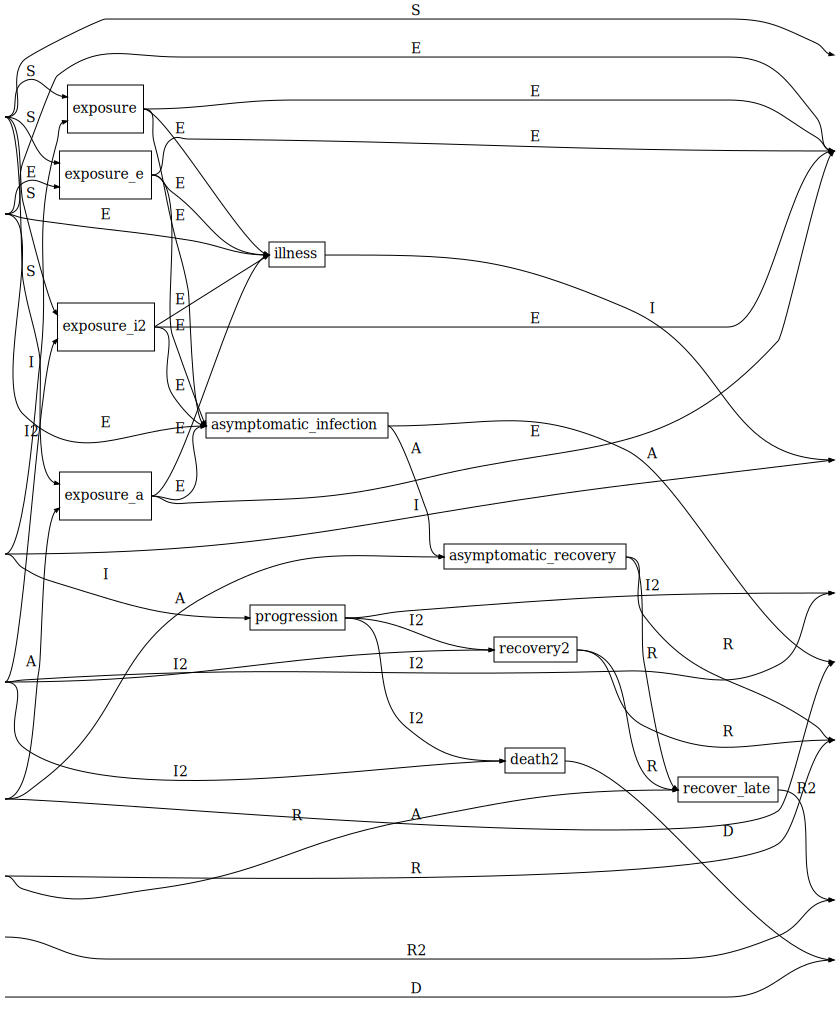

In [7]:
coexist = @program EpiCoexist (s::S, e::E, i::I, i2::I2, a::A, r::R, r2::R2, d::D) begin
    e_2 = exposure(s, i)
    e_3 = exposure_i2(s, i2)
    e_4 = exposure_a(s, a)
    e_5 = exposure_e(s, e)
    e_all = [e, e_2, e_3, e_4, e_5]
    a_2 = asymptomatic_infection(e_all)
    a_all = [a, a_2]
    r_2 = asymptomatic_recovery(a_all)
    i_2 = illness(e_all)
    i_all = [i, i_2]
    i2_2 = progression(i)
    i2_all = [i2, i2_2]
    d_2 = death2(i2_all)
    r_3 = recovery2(i2_all)
    r_all = [r, r_2, r_3]
    r2_2 = recover_late(r_all)
    r2_all = [r2, r2_2]
    d_all = [d, d_2]
    return s, e_all, i_all, i2_all, a_all, r_all, r2_all, d_all
end;
coexist = to_hom_expr(FreeBiproductCategory, coexist);
display_wd(coexist)

Define a new presentation and functor to use in modeling
cross exposure between two sets of populations

In [8]:
@present EpiCrossExposure(FreeBiproductCategory) begin
    (S,E,A,I,I2,R,R2,D)::Ob
    (S′,E′,A′,I′,I2′,R′,R2′,D′)::Ob

    exposure::Hom(S⊗I′,E)
    exposure_e::Hom(S⊗E′,E)
    exposure_a::Hom(S⊗A′,E)
    exposure_i2::Hom(S⊗I2′,E)
    exposure′::Hom(S′⊗I,E′)
    exposure_e′::Hom(S′⊗E,E′)
    exposure_a′::Hom(S′⊗A,E′)
    exposure_i2′::Hom(S′⊗I2,E′)
end;

ce_S,ce_E,ce_A,ce_I,ce_I2,ce_R,ce_R2,ce_D, ce_S′,ce_E′,ce_A′,ce_I′,ce_I2′,ce_R′,ce_R2′,ce_D′, ce_exposure, ce_exposure_e, ce_exposure_a, ce_exposure_i2, ce_exposure′, ce_exposure_e′, ce_exposure_a′, ce_exposure_i2′ = generators(EpiCrossExposure);

F_cx(ex, x,y) = functor((OpenEpiRxnNetOb, OpenEpiRxnNet), ex, generators=Dict(
    ce_S=>ob(Symbol(:S, x), pop[x]),
    ce_E=>ob(Symbol(:E, x), 1000),
    ce_A=>ob(Symbol(:A, x), 1000),
    ce_I=>ob(Symbol(:I, x), 1000),
    ce_I2=>ob(Symbol(:I2, x), 1000),
    ce_R=>ob(Symbol(:R, x), 0),
    ce_R2=>ob(Symbol(:R2, x), 0),
    ce_D=>ob(Symbol(:D, x), 0),
    ce_S′=>ob(Symbol(:S, y), pop[y]),
    ce_E′=>ob(Symbol(:E, y), 1000),
    ce_A′=>ob(Symbol(:A, y), 1000),
    ce_I′=>ob(Symbol(:I, y), 1000),
    ce_I2′=>ob(Symbol(:I2, y), 1000),
    ce_R′=>ob(Symbol(:R, y), 0),
    ce_R2′=>ob(Symbol(:R2, y), 0),
    ce_D′=>ob(Symbol(:D, y), 0),
    ce_exposure=>exposure_petri(Symbol(:exp_, x,y), 1*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:I,y), 1000, Symbol(:E,x), 1000),
    ce_exposure_e=>exposure_petri(Symbol(:exp_e, x,y), .01*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:E,y),1000, Symbol(:E,x),1000),
    ce_exposure_a=>exposure_petri(Symbol(:exp_a, x,y), 5*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:A,y),1000, Symbol(:E,x),1000),
    ce_exposure_i2=>exposure_petri(Symbol(:exp_i2, x,y), 6*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:I2,y), 1000, Symbol(:E,x),1000),
    ce_exposure′=>exposure_petri(Symbol(:exp_, y,x), 1*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:I,x), 1000, Symbol(:E,y), 1000),
    ce_exposure_e′=>exposure_petri(Symbol(:exp_e, y,x), .01*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:E,x),1000, Symbol(:E,y),1000),
    ce_exposure_a′=>exposure_petri(Symbol(:exp_a, y,x), 5*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:A,x),1000, Symbol(:E,y),1000),
    ce_exposure_i2′=>exposure_petri(Symbol(:exp_i2, y,x), 6*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:I2,x), 1000, Symbol(:E,y),1000)
));

Use this new presentation to define a model
of cross exposure between two populations

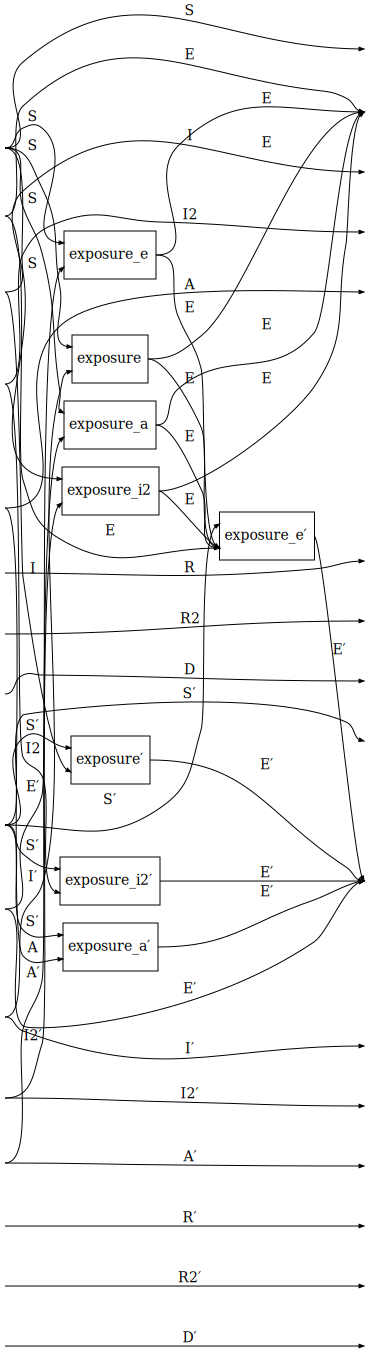

In [9]:
crossexposure = @program EpiCrossExposure (s::S, e::E, i::I, i2::I2, a::A, r::R, r2::R2, d::D,
                                           s′::S′, e′::E′, i′::I′, i2′::I2′, a′::A′, r′::R′, r2′::R2′, d′::D′) begin
    e_2 = exposure(s, i′)
    e_3 = exposure_i2(s, i2′)
    e_4 = exposure_a(s, a′)
    e_5 = exposure_e(s, e′)
    e_all = [e, e_2, e_3, e_4, e_5]
    e′_2 = exposure′(s′, i)
    e′_3 = exposure_i2′(s′, i2)
    e′_4 = exposure_a′(s′, a)
    e′_5 = exposure_e′(s′, e_all)
    e′_all = [e′, e′_2, e′_3, e′_4, e′_5]
    return s, e_all, i, i2, a, r, r2, d,
           s′, e′_all, i′, i2′, a′, r′, r2′, d′
end;
crossexposure = to_hom_expr(FreeBiproductCategory, crossexposure);
display_wd(crossexposure)

To combine these two models, we need a final presentation
that enables us to model 3 populations, each with their
own COEXIST model, and interact through cross exposure

In [10]:
@present ThreeCoexist(FreeBiproductCategory) begin
    (Pop1,Pop2,Pop3)::Ob

    crossexp12::Hom(Pop1⊗Pop2,Pop1⊗Pop2)
    crossexp13::Hom(Pop1⊗Pop3,Pop1⊗Pop3)
    crossexp23::Hom(Pop2⊗Pop3,Pop2⊗Pop3)
    coex1::Hom(Pop1,Pop1)
    coex2::Hom(Pop2,Pop2)
    coex3::Hom(Pop3,Pop3)
end;
Pop1, Pop2, Pop3, crossexp12, crossexp13, crossexp23, coex1, coex2, coex3 = generators(ThreeCoexist);

F_tcx(ex) = functor((OpenEpiRxnNetOb, OpenEpiRxnNet), ex, generators=Dict(
    Pop1=>F(otimes(S,E,I,I2,A,R,R2,D),3),
    Pop2=>F(otimes(S,E,I,I2,A,R,R2,D),4),
    Pop3=>F(otimes(S,E,I,I2,A,R,R2,D),5),
    crossexp12=>F_cx(crossexposure,3,4),
    crossexp13=>F_cx(crossexposure,3,5),
    crossexp23=>F_cx(crossexposure,4,5),
    coex1=>F(coexist,3),
    coex2=>F(coexist,4),
    coex3=>F(coexist,5)
    ));

Use this presentation to define this
three-generational COEXIST model

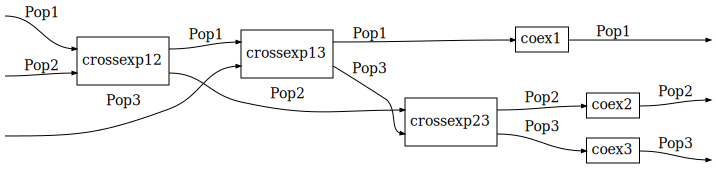

In [11]:
threeNCoexist = @program ThreeCoexist (pop1::Pop1, pop2::Pop2, pop3::Pop3) begin
    pop1′, pop2′ = crossexp12(pop1, pop2)
    pop1′′, pop3′ = crossexp13(pop1′, pop3)
    pop2′′, pop3′′ = crossexp23(pop2′, pop3′)
    return coex1(pop1′′), coex2(pop2′′), coex3(pop3′′)
end;
threeNCoexist = to_hom_expr(FreeBiproductCategory, threeNCoexist);
display_wd(threeNCoexist)

Once this final model has been defined, we can use
the functors to get the underlying Petri net

┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0
┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0


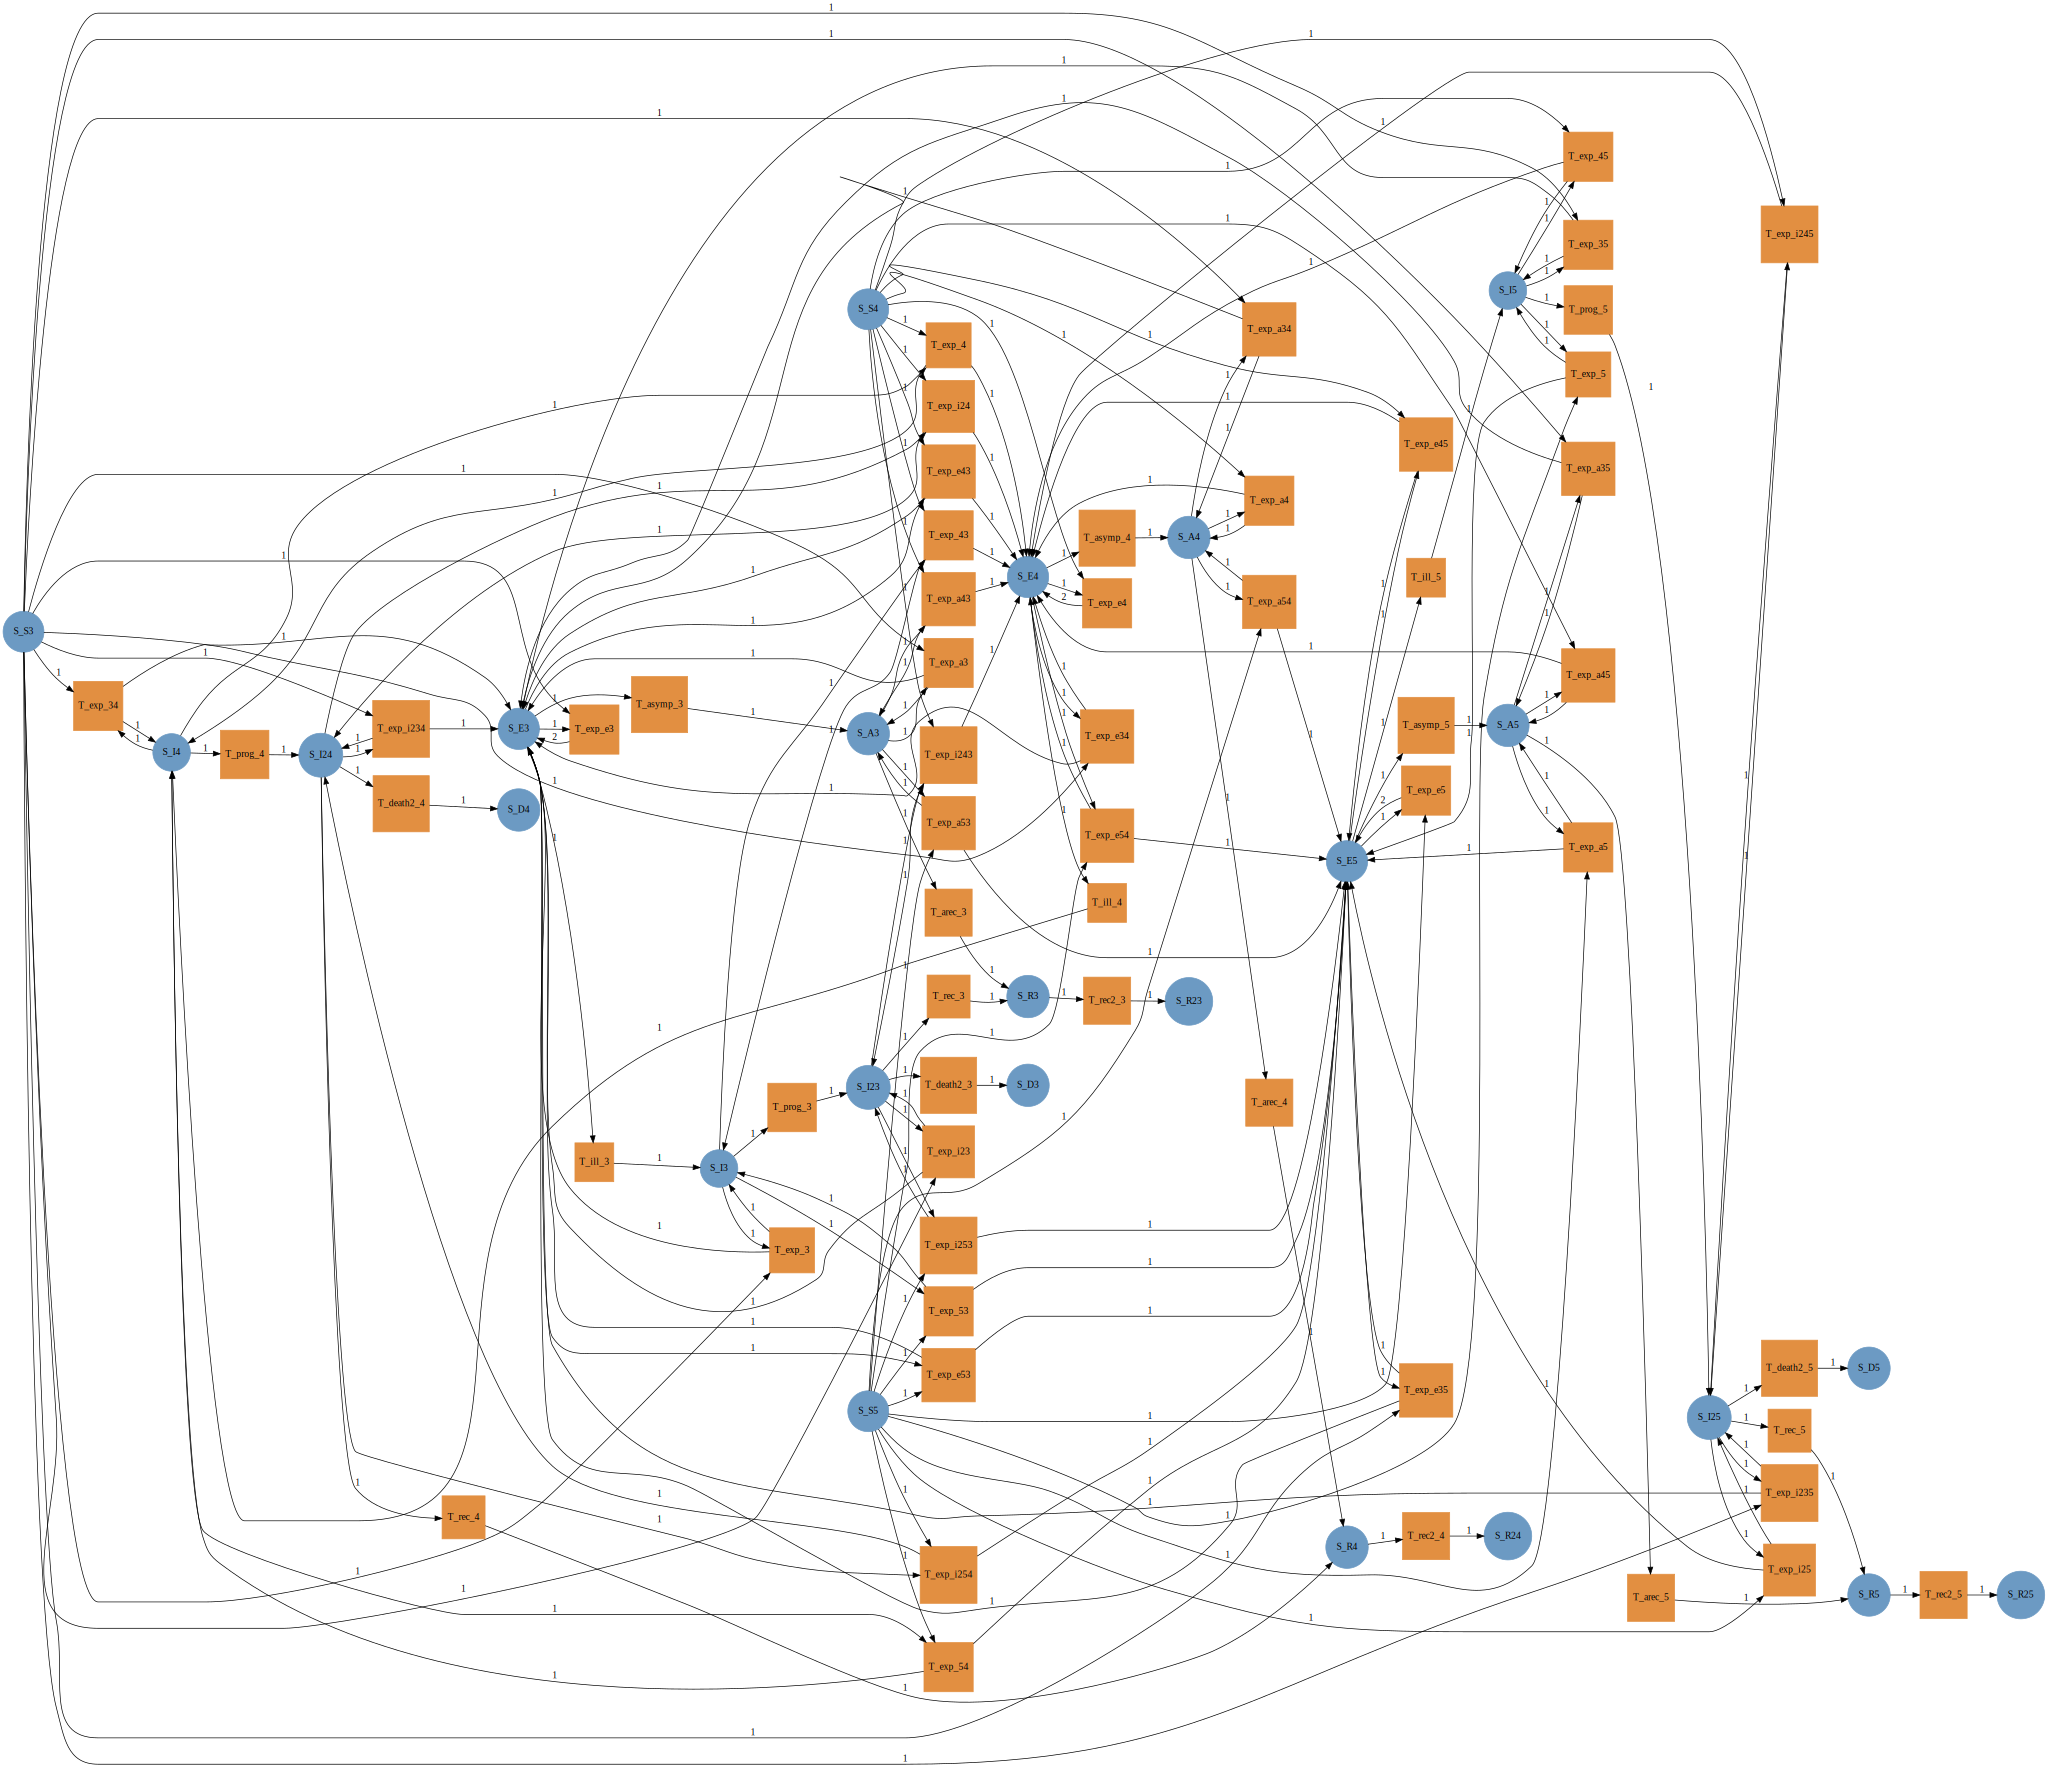

In [12]:
threeNCoexist_algpetri = apex(F_tcx(threeNCoexist))
threeNCoexist_petri = Petri.Model(threeNCoexist_algpetri)
Graph(threeNCoexist_algpetri)

We can JSON to convert this Petri net into an
easily shareable format

In [13]:
JSON.print(threeNCoexist_algpetri.tables)

{"T":[{"rate":1.0158516804620892e-7,"tname":"exp_34"},{"rate":1.0158516804620891e-9,"tname":"exp_e34"},{"rate":8.777910996417687e-8,"tname":"exp_43"},{"rate":5.266746597850612e-7,"tname":"exp_i243"},{"rate":4.3889554982088435e-7,"tname":"exp_a43"},{"rate":6.095110082772535e-7,"tname":"exp_i234"},{"rate":5.079258402310445e-7,"tname":"exp_a34"},{"rate":8.777910996417687e-10,"tname":"exp_e43"},{"rate":1.052534350405119e-7,"tname":"exp_35"},{"rate":1.052534350405119e-9,"tname":"exp_e35"},{"rate":9.327595965846783e-8,"tname":"exp_53"},{"rate":5.596557579508069e-7,"tname":"exp_i253"},{"rate":4.6637979829233916e-7,"tname":"exp_a53"},{"rate":6.315206102430715e-7,"tname":"exp_i235"},{"rate":5.262671752025595e-7,"tname":"exp_a35"},{"rate":9.327595965846782e-10,"tname":"exp_e53"},{"rate":1.0877573746279346e-7,"tname":"exp_45"},{"rate":1.0877573746279345e-9,"tname":"exp_e45"},{"rate":1.1155900042152166e-7,"tname":"exp_54"},{"rate":6.6935400252913e-7,"tname":"exp_i254"},{"rate":5.577950021076083e-7

We can now easily generate a solver for DifferentialEquations.jl
because we encoded the intitial parameters and rates throughout
the construction of the model, the final result knows its
concentrations and rates.

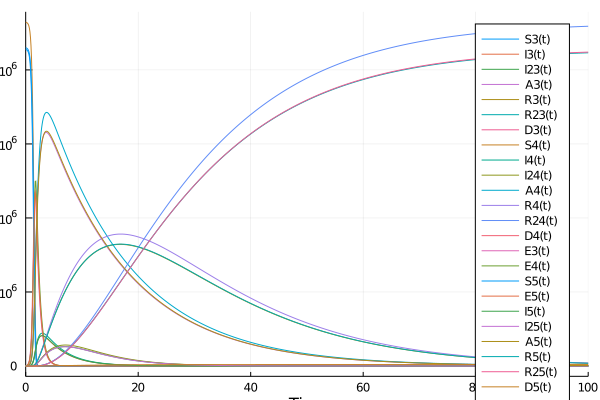

In [14]:
tspan = (0.0,100.0);
prob = ODEProblem(threeNCoexist_petri,concentrations(threeNCoexist_algpetri),tspan,rates(threeNCoexist_algpetri));
sol = solve(prob,Tsit5());
plot(sol, xlabel="Time", ylabel="Number of people")

If we want to model other intervention methods,
we can simply adjust the rates of exposure to
represent stay at home orders and mask wearing.
Because of how we have defined our rates, we can
simply update the social mixing rates, and
resolve the model.

┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0
┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0


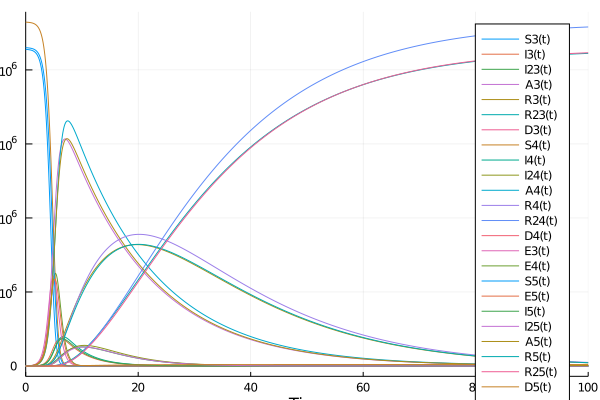

In [15]:
for i in 1:length(social_mixing_rate)
  for j in 1:length(social_mixing_rate[1])
    if i != j
      social_mixing_rate[i][j] = social_mixing_rate[i][j] / 10;
    else
      social_mixing_rate[i][j] = social_mixing_rate[i][j] / 5;
    end
  end
end
threeNCoexist_algpetri = apex(F_tcx(threeNCoexist));
threeNCoexist_petri = Petri.Model(threeNCoexist_algpetri);

prob = ODEProblem(threeNCoexist_petri,concentrations(threeNCoexist_algpetri),tspan,rates(threeNCoexist_algpetri));
sol = solve(prob,Tsit5());
plot(sol, xlabel="Time", ylabel="Number of people")